In [1]:
import torch
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import clear_output
from time import sleep
import os
import numpy as np

from keras.layers import Conv2D,Dropout,Dense,Flatten
from keras.models import Sequential
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.layers import Activation, Convolution2D, MaxPooling2D, BatchNormalization, Flatten, Dense, Dropout, Conv2D,MaxPool2D, ZeroPadding2D

Using TensorFlow backend.


In [2]:
TRAIN_DATA_PATH = '../data/training.csv'
TEST_DATA_PATH = '../data/test.csv'
ID_TABLE_PATH = '../data/IdLookupTable.csv'
train_data = pd.read_csv(TRAIN_DATA_PATH)  
test_data = pd.read_csv(TEST_DATA_PATH)
lookid_data = pd.read_csv(ID_TABLE_PATH)
os.listdir('../data')

['training.csv',
 'IdLookupTable.csv',
 'SampleSubmission.csv',
 'test.csv',
 'README.md',
 '.gitignore']

In [3]:
# analyze the data
train_data.head().T

,0,1,2,3,4
left_eye_center_x,66.0336,64.3329,65.0571,65.2257,66.7253
left_eye_center_y,39.0023,34.9701,34.9096,37.2618,39.6213
right_eye_center_x,30.227,29.9493,30.9038,32.0231,32.2448
right_eye_center_y,36.4217,33.4487,34.9096,37.2618,38.042
left_eye_inner_corner_x,59.5821,58.8562,59.412,60.0033,58.5659
left_eye_inner_corner_y,39.6474,35.2743,36.321,39.1272,39.6213
left_eye_outer_corner_x,73.1303,70.7227,70.9844,72.3147,72.5159
left_eye_outer_corner_y,39.97,36.1872,36.321,38.381,39.8845
right_eye_inner_corner_x,36.3566,36.0347,37.6781,37.6186,36.9824
right_eye_inner_corner_y,37.3894,34.3615,36.321,38.7541,39.0949


In [4]:
train_data.isnull().any()#.value_counts()

left_eye_center_x             True
left_eye_center_y             True
right_eye_center_x            True
right_eye_center_y            True
left_eye_inner_corner_x       True
left_eye_inner_corner_y       True
left_eye_outer_corner_x       True
left_eye_outer_corner_y       True
right_eye_inner_corner_x      True
right_eye_inner_corner_y      True
right_eye_outer_corner_x      True
right_eye_outer_corner_y      True
left_eyebrow_inner_end_x      True
left_eyebrow_inner_end_y      True
left_eyebrow_outer_end_x      True
left_eyebrow_outer_end_y      True
right_eyebrow_inner_end_x     True
right_eyebrow_inner_end_y     True
right_eyebrow_outer_end_x     True
right_eyebrow_outer_end_y     True
nose_tip_x                   False
nose_tip_y                   False
mouth_left_corner_x           True
mouth_left_corner_y           True
mouth_right_corner_x          True
mouth_right_corner_y          True
mouth_center_top_lip_x        True
mouth_center_top_lip_y        True
mouth_center_bottom_

In [5]:
# fill nan/null values with the val
train_data.fillna(method = 'ffill',inplace = True)
train_data.isnull().any().value_counts()

False    31
dtype: int64

In [6]:
images_filled = [[0 if c is '' else float(c) for c in image.split(' ')] for image in train_data['Image']]

In [7]:
lens = {}
for image in images_filled:
  lens[len(image)] = (lens.get(len(image)) or 0) + 1
  for c in image:
    if not isinstance(c, float): print('not float')
print(lens)

{9216: 7049}


In [11]:
print(images_filled[0])
images = np.array(images_filled, dtype='float')
x_train = images.reshape(-1, 96, 96, 1)

['238', '236', '237', '238', '240', '240', '239', '241', '241', '243', '240', '239', '231', '212', '190', '173', '148', '122', '104', '92', '79', '73', '74', '73', '73', '74', '81', '74', '60', '64', '75', '86', '93', '102', '100', '105', '109', '114', '121', '127', '132', '134', '137', '137', '140', '139', '138', '137', '137', '140', '141', '143', '144', '147', '148', '149', '147', '147', '148', '145', '147', '144', '146', '147', '147', '143', '134', '130', '130', '128', '116', '104', '98', '90', '82', '78', '85', '88', '86', '80', '77', '87', '108', '111', '115', '128', '133', '188', '242', '252', '250', '248', '251', '250', '250', '250', '235', '238', '236', '238', '238', '237', '238', '242', '241', '239', '237', '233', '215', '195', '187', '156', '119', '103', '93', '78', '68', '73', '75', '75', '72', '75', '70', '61', '66', '77', '91', '96', '106', '108', '113', '120', '125', '131', '134', '138', '135', '138', '139', '145', '144', '144', '142', '140', '141', '141', '148', '147', '

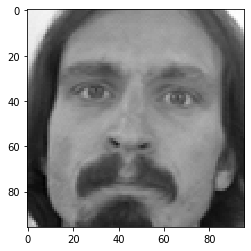

In [12]:
plt.imshow(x_train[0].reshape(96,96),cmap='gray')
plt.show()

In [13]:
keypoints_raw = train_data.drop('Image', axis='columns')
y_train = np.array([keypoints_raw.iloc[i, :] for i in range(0, len(keypoints_raw))], dtype='float')

In [14]:
"""model_simple = Sequential([
    Flatten(input_shape=(96,96)),
    Dense(128, activation="relu"),
    Dropout(0.1),
    Dense(64, activation="relu"),
    Dense(30)
])
model_simple.summary()"""

'model_simple = Sequential([\n    Flatten(input_shape=(96,96)),\n    Dense(128, activation="relu"),\n    Dropout(0.1),\n    Dense(64, activation="relu"),\n    Dense(30)\n])\nmodel_simple.summary()'

In [15]:
model = Sequential()

model.add(Convolution2D(32, (3,3), padding='same', use_bias=False, input_shape=(96,96,1)))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())

model.add(Convolution2D(32, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Convolution2D(64, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())

model.add(Convolution2D(64, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Convolution2D(96, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())

model.add(Convolution2D(96, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Convolution2D(128, (3,3),padding='same', use_bias=False))
# model.add(BatchNormalization())
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())

model.add(Convolution2D(128, (3,3),padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Convolution2D(256, (3,3),padding='same',use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())

model.add(Convolution2D(256, (3,3),padding='same',use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Convolution2D(512, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())

model.add(Convolution2D(512, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())


model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(30))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 96, 96, 32)        288       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 96, 96, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 96, 96, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 96, 96, 32)        9216      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 96, 96, 32)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 96, 96, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 32)       

In [16]:
model.compile(optimizer='adam', 
              loss='mean_squared_error',
              metrics=['mae'])

In [ ]:
model.fit(x_train,y_train,epochs = 50,batch_size = 256,validation_split = 0.2, verbose=1)

Train on 5639 samples, validate on 1410 samples
Epoch 1/50
